# Define globals:

In [1]:
input_size = 100
output_size = 24 # we have 24 labels after filter
hidden_size = 128
learning_rate = 4e-4
batch_size = 24
num_epochs = 15

# Load dataset:

In [2]:
from components.models.utils import train_test_split
from components.datasets.dataset_enum import Dataset as DatasetEnum
from components.datasets.dataset_factory import dataset_factory
from components.text_handler.embedding.embedding_enum import EmbeddingType
from components.text_handler.embedding.embedding_factory import embedding_factory

embedding = embedding_factory(EmbeddingType.GLOVE)
dataset = dataset_factory(DatasetEnum.GO_EMOTIONS, embedding)
train_phrases, test_phrases, train_dataset_data, test_dataset_data, train_dataset_labels, test_dataset_labels = train_test_split(dataset, 0.9)
train_size = len(train_dataset_data)
test_size = len(test_dataset_data)

# Define data loaders

In [3]:
from components.utils import MyDataset, collect_batch
from torch.utils.data import DataLoader
import torch

train_dataset = MyDataset(train_phrases, train_dataset_data, train_dataset_labels)
test_dataset = MyDataset(test_phrases, test_dataset_data, test_dataset_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=1, shuffle=True, collate_fn=collect_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=1, shuffle=False, collate_fn=collect_batch)

# Create model:

In [4]:
from torch import nn
import os
from components.models.algorithms.algorithm_factory import algorithms_factory
from components.models.algorithms.algorithms_enum import ClassifierAlgorithm

dirname = os.path.dirname("__file__")
saved_data_path = os.path.join(dirname, "components")
saved_data_path = os.path.join(saved_data_path, "models")
saved_data_path = os.path.join(saved_data_path, "saved_models")
device = torch.device('cpu')

model = algorithms_factory(ClassifierAlgorithm.GRU, input_size, output_size, hidden_size, device)
PATH = os.path.join(saved_data_path, f"{model.get_model_name()}.pth")
if os.path.exists(PATH):
    model.load_state_dict(torch.load(PATH))

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define metrics objects:

In [5]:
from torchmetrics import Recall, F1Score, Precision
from components.models.algorithms.feed_nn_model import TRAIN, TEST, LOSS, RECALL, F1_SCORE, PRECISION

recall = Recall().to(device)
f1 = F1Score().to(device)
precision = Precision().to(device)

measurements = {
    LOSS: {TRAIN: [], TEST: []},
    RECALL: {TRAIN: [], TEST: []},
    F1_SCORE: {TRAIN: [], TEST: []},
    PRECISION: {TRAIN: [], TEST: []}
}

# Train model:

In [6]:
from tqdm import tqdm
from components.models.algorithms.feed_nn_model import feed_model

print(f'Training {model.get_model_name()} model')

for epoch in tqdm(range(num_epochs)):

    # train the model
    model.train()
    feed_model(model, train_loader, criterion, optimizer, recall, f1, precision, measurements, TRAIN)

    # test the model
    model.eval()
    feed_model(model, test_loader, criterion, optimizer, recall, f1, precision, measurements, TEST)

    torch.save(model.state_dict(), PATH)


Training GRU model


100%|██████████| 15/15 [1:30:25<00:00, 361.72s/it]


Plotting results:

            train    test
loss       0.0502  0.0701
recall     0.6806  0.6099
F1 score   0.7462  0.6754
precision  0.8303  0.7612


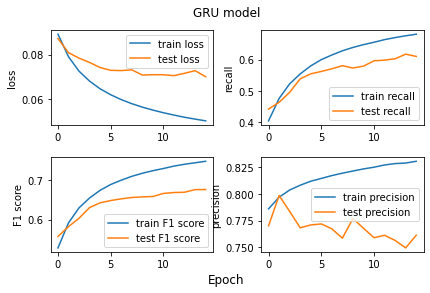

In [7]:
from matplotlib import pyplot as plt
import pandas as pd

result_df = pd.DataFrame({
    TRAIN: {
        LOSS: 0.0,
        RECALL: 0.0,
        F1_SCORE: 0.0,
        PRECISION: 0.0
    },
    TEST: {
        LOSS: 0.0,
        RECALL: 0.0,
        F1_SCORE: 0.0,
        PRECISION: 0.0
    }
})

if len(measurements[LOSS][TRAIN]):
    print("Plotting results:\n")
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    subplots = [ax1, ax2, ax3, ax4]
    fig.suptitle(f'{model.get_model_name()} model')
    for index, (measurement_key, measurement) in enumerate(measurements.items()):
        result_df[TRAIN][measurement_key] = measurement[TRAIN][-1]
        result_df[TEST][measurement_key] = measurement[TEST][-1]
        subplot = subplots[index]
        subplot.plot(measurement[TRAIN], label=f'train {measurement_key}')
        subplot.plot(measurement[TEST], label=f'test {measurement_key}')
        subplot.set_ylabel(measurement_key)
        subplot.legend()
    fig.supxlabel('Epoch')
    plt.savefig(os.path.join('results', f'{model.get_model_name()}.png'), dpi=300)
    plt.plot()
    result_df = result_df.round(4)
    print(result_df)
    result_df.to_csv(os.path.join('results', f'{model.get_model_name()}.csv'))
else:
    print("You didn't run the training step!")